In [1]:
import os
import json
import time
import math
import matplotlib.pyplot as plt
from core.data_processor import DataLoader
from core.model import Model


def plot_results(predicted_data, true_data):
    fig = plt.figure(facecolor='white',figsize=(16,9))
    ax = fig.add_subplot(111)
    ax.plot(true_data, label='True Data')
    plt.plot(predicted_data, label='Prediction')
    plt.legend()
    plt.show()


def plot_results_multiple(predicted_data, true_data, prediction_len, name):
    fig = plt.figure(facecolor='white',figsize=(16,9))
    ax = fig.add_subplot(111)
    ax.plot(true_data, label='True Data')
    # Pad the list of predictions to shift it in the graph to it's correct start
    for i, data in enumerate(predicted_data):
        padding = [None for p in range(i * prediction_len)]
        plt.plot(padding + data, label='Prediction')
        plt.legend(loc='upper left', fontsize=7)
    plt.savefig("./picture/%s.png"%name)
    plt.show()

## 加载配置文件及组装模型

In [2]:
# main
configs = json.load(open('config2.json', 'r'))
if not os.path.exists(configs['model']['save_dir']): os.makedirs(configs['model']['save_dir'])

data = DataLoader(
    os.path.join('data', configs['data']['filename']),
    configs['data']['train_test_split'],
    configs['data']['columns'],
    configs['data']['drop']
)

model = Model()
model.build_model(configs)
x, y = data.get_train_data(
    seq_len=configs['data']['sequence_length'],
    normalise=configs['data']['normalise']
)

[Model] Model Compiled
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 19, 100)           47200     
_________________________________________________________________
dropout (Dropout)            (None, 19, 100)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 19, 100)           80400     
_________________________________________________________________
lstm_2 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
Total params: 208,101
Trainable params: 208,101
Non-trainable params: 0
___________________________

## 模型训练及模型加载

In [3]:

'''
# in-memory training
model.train(
    x,
    y,
    epochs = configs['training']['epochs'],
    batch_size = configs['training']['batch_size'],
    save_dir = configs['model']['save_dir']
)
'''
# out-of memory generative training
steps_per_epoch = math.ceil(
    (data.len_train - configs['data']['sequence_length']) / configs['training']['batch_size'])

model.train_generator(
    data_gen=data.generate_train_batch(
        seq_len=configs['data']['sequence_length'],
        batch_size=configs['training']['batch_size'],
        normalise=configs['data']['normalise']
    ),
    epochs=configs['training']['epochs'],
    batch_size=configs['training']['batch_size'],
    steps_per_epoch=steps_per_epoch,
    save_dir=configs['model']['save_dir']
)

# model.load_model(os.path.join(configs['model']['save_dir'], "07022021-150019-e2.h5"))

x_test, y_test = data.get_test_data(
    seq_len=configs['data']['sequence_length'],
    normalise=configs['data']['normalise']
)

[Model] Training Started
[Model] 2 epochs, 32 batch size, 74 batches per epoch
Epoch 1/2
74/74 [==============================] - 7s 90ms/step - loss: 0.0045
Epoch 2/2
74/74 [==============================] - 3s 41ms/step - loss: 0.0020
[Model] Training Completed. Model saved as saved_models\14022021-100015-e2.h5
Time taken: 0:00:09.727016


[Model] Predicting Sequences Multiple...


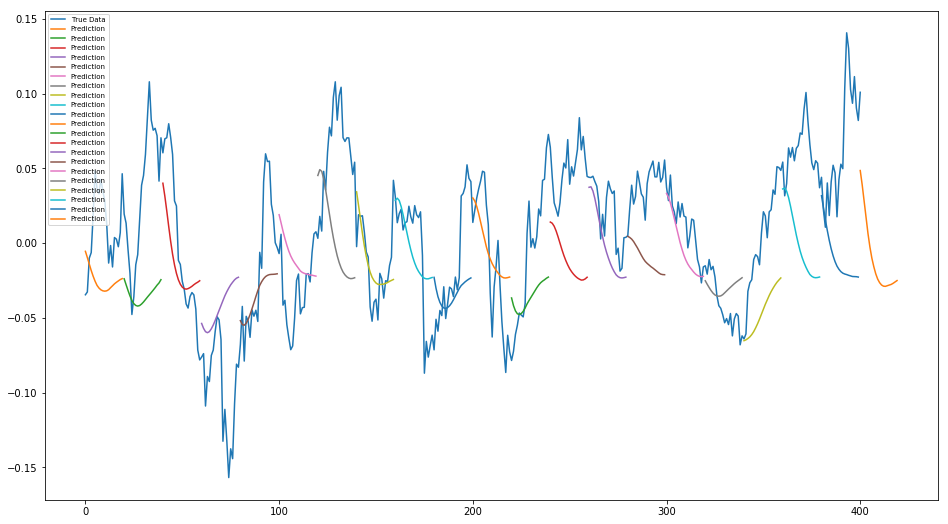

In [4]:
predictions = model.predict_sequences_multiple(x_test, configs['data']['sequence_length'],configs['data']['sequence_length'])
# predictions = model.predict_sequence_full(x_test, configs['data']['sequence_length'])
# predictions = model.predict_point_by_point(x_test)

plot_results_multiple(predictions, y_test, configs['data']['sequence_length'],",".join(configs['data']['columns']))
# plot_results(predictions, y_test)

In [5]:
# predictions = model.predict_point_by_point(x_test)
# plot_results(predictions, y_test)